In [1]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"


In [2]:
import torch
from torch.utils.data import DataLoader
from sentence_transformers import SentenceTransformer, InputExample, losses
from sklearn.model_selection import train_test_split
import pandas as pd
from tqdm import tqdm

# === Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# === Carrega les dades
df = pd.read_csv("parelles.csv").dropna()
examples = [InputExample(texts=[row['text_a'], row['text_b']], label=float(row['label'])) for _, row in df.iterrows()]
train_examples, test_examples = train_test_split(examples, test_size=0.2, random_state=42)

c:\Users\MGestioTI\Desktop\tfg\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
W0613 20:31:12.686000 14376 Lib\site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


Device: cuda


In [3]:
# Analitza longituds
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("nomic-ai/modernbert-embed-base")
df["len_a"] = df["text_a"].apply(lambda x: len(tokenizer.tokenize(str(x))))
df["len_b"] = df["text_b"].apply(lambda x: len(tokenizer.tokenize(str(x))))
df["max_len"] = df[["len_a", "len_b"]].max(axis=1)
print("Percentil 95 llargada màxima:", df["max_len"].quantile(0.95))


Token indices sequence length is longer than the specified maximum sequence length for this model (8833 > 8192). Running this sequence through the model will result in indexing errors


Percentil 95 llargada màxima: 2604.0


In [4]:
# === Model i loss
model = SentenceTransformer("nomic-ai/modernbert-embed-base")
model.max_seq_length = 512  # no més
model.to(device)
train_loss = losses.ContrastiveLoss(model=model, distance_metric=losses.SiameseDistanceMetric.COSINE_DISTANCE)

# === Dataloader amb collate
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=2, collate_fn=model.smart_batching_collate)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

# === Entrenament manual
model.train()
for epoch in range(3):
    total_loss = 0
    for features, labels in tqdm(train_dataloader, desc="Training"):
        # Moure cada diccionari de la llista a GPU
        features = [{k: v.to(device) for k, v in feature.items()} for feature in features]
        labels = labels.to(device)

        optimizer.zero_grad()
        loss = train_loss(features, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        del features, labels, loss
        torch.cuda.empty_cache()

    print(f"Epoch completed. Loss: {total_loss:.4f}")

# === Guarda el model
model.save("output/modernbert-contrastive-manual")


c:\Users\MGestioTI\Desktop\tfg\.venv\Lib\site-packages\torch\nn\modules\module.py:1341: UserWarning: expandable_segments not supported on this platform (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\c10/cuda/CUDAAllocatorConfig.h:28.)
  return t.to(
Training: 100%|██████████| 13309/13309 [2:41:57<00:00,  1.37it/s] 


Epoch completed. Loss: 40.2623


Training: 100%|██████████| 13309/13309 [1:59:09<00:00,  1.86it/s] 


Epoch completed. Loss: 9.9518


Training: 100%|██████████| 13309/13309 [1:59:13<00:00,  1.86it/s] 


Epoch completed. Loss: 4.3359


In [5]:
from sklearn.metrics import roc_auc_score, accuracy_score
from torch.nn.functional import cosine_similarity
import numpy as np

model.eval()

emb1_list = []
emb2_list = []
y_true = []
y_scores = []

with torch.no_grad():
    for example in tqdm(test_examples, desc="Testing"):
        emb1 = model.encode(example.texts[0], convert_to_tensor=True, device=device)
        emb2 = model.encode(example.texts[1], convert_to_tensor=True, device=device)
        sim = cosine_similarity(emb1.unsqueeze(0), emb2.unsqueeze(0)).item()

        emb1_list.append(emb1.cpu().numpy())
        emb2_list.append(emb2.cpu().numpy())
        y_true.append(example.label)
        y_scores.append(sim)

# === Mètriques
auc = roc_auc_score(y_true, y_scores)
acc = accuracy_score(y_true, [1 if s > 0.5 else 0 for s in y_scores])

print(f"📈 AUC: {auc:.4f}")
print(f"✅ Accuracy (umbral 0.5): {acc:.4f}")


Testing: 100%|██████████| 6655/6655 [09:17<00:00, 11.93it/s]

📈 AUC: 0.9998
✅ Accuracy (umbral 0.5): 0.9901


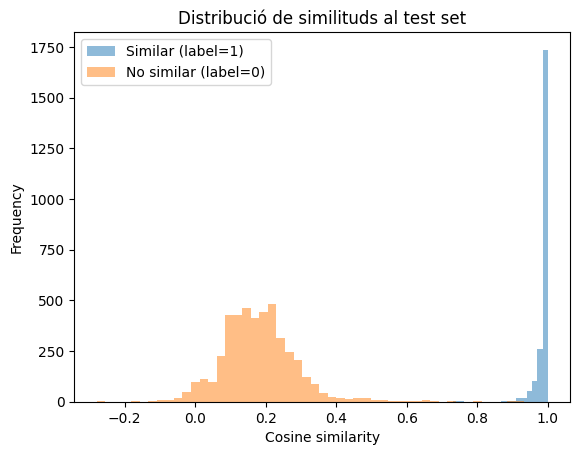

In [6]:
import matplotlib.pyplot as plt

plt.hist([s for s, y in zip(y_scores, y_true) if y == 1], bins=50, alpha=0.5, label="Similar (label=1)")
plt.hist([s for s, y in zip(y_scores, y_true) if y == 0], bins=50, alpha=0.5, label="No similar (label=0)")
plt.xlabel("Cosine similarity")
plt.ylabel("Frequency")
plt.legend()
plt.title("Distribució de similituds al test set")
plt.show()


In [40]:
from sklearn.metrics import f1_score

# Prova diversos llindars
thresholds = np.linspace(0, 1, 100)
f1s = [f1_score(y_true, [1 if s >= t else 0 for s in y_scores]) for t in thresholds]

# Troba el millor llindar
best_idx = np.argmax(f1s)
best_threshold = thresholds[best_idx]
print(f"Millor llindar segons F1-score: {best_threshold:.2f} (F1 = {f1s[best_idx]:.4f})")


Millor llindar segons F1-score: 0.84 (F1 = 0.9964)


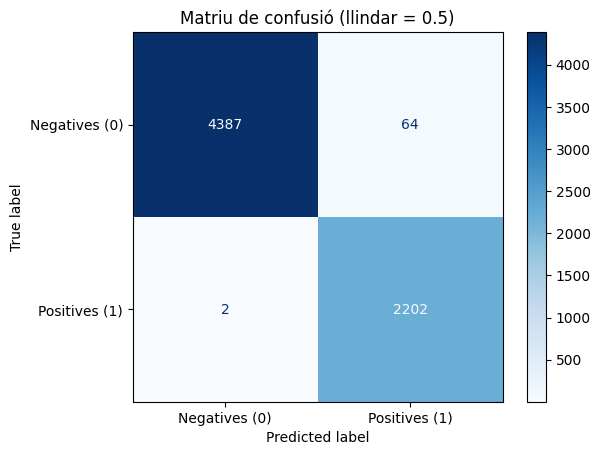

🔢 Valors:
TN (negatives correctes): 4387
FP (falsos positius):     64
FN (falsos negatius):     2
TP (positives correctes): 2202


In [42]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# ───────────────────────────────────────────────────
# Tria un llindar per fer classificació binària
llindar = 0.5  # ajustable

# Generem prediccions: si similitud > llindar → positiva
prediccions = [1 if s >= llindar else 0 for s in y_scores]

# ───────────────────────────────────────────────────
# Matriu de confusió
cm = confusion_matrix(y_true, prediccions)
labels = ["Negatives (0)", "Positives (1)"]

# Mostrem matriu
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Blues")
plt.title(f"Matriu de confusió (llindar = {llindar})")
plt.show()

# També mostrem les xifres
tn, fp, fn, tp = cm.ravel()
print("🔢 Valors:")
print(f"TN (negatives correctes): {tn}")
print(f"FP (falsos positius):     {fp}")
print(f"FN (falsos negatius):     {fn}")
print(f"TP (positives correctes): {tp}")


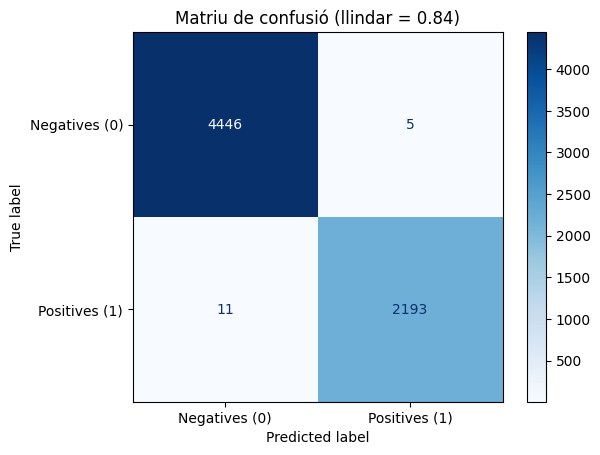

🔢 Valors:
TN (negatives correctes): 4446
FP (falsos positius):     5
FN (falsos negatius):     11
TP (positives correctes): 2193


In [43]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# ───────────────────────────────────────────────────
# Tria un llindar per fer classificació binària
llindar = 0.84  # ajustable

# Generem prediccions: si similitud > llindar → positiva
prediccions = [1 if s >= llindar else 0 for s in y_scores]

# ───────────────────────────────────────────────────
# Matriu de confusió
cm = confusion_matrix(y_true, prediccions)
labels = ["Negatives (0)", "Positives (1)"]

# Mostrem matriu
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Blues")
plt.title(f"Matriu de confusió (llindar = {llindar})")
plt.show()

# També mostrem les xifres
tn, fp, fn, tp = cm.ravel()
print("🔢 Valors:")
print(f"TN (negatives correctes): {tn}")
print(f"FP (falsos positius):     {fp}")
print(f"FN (falsos negatius):     {fn}")
print(f"TP (positives correctes): {tp}")


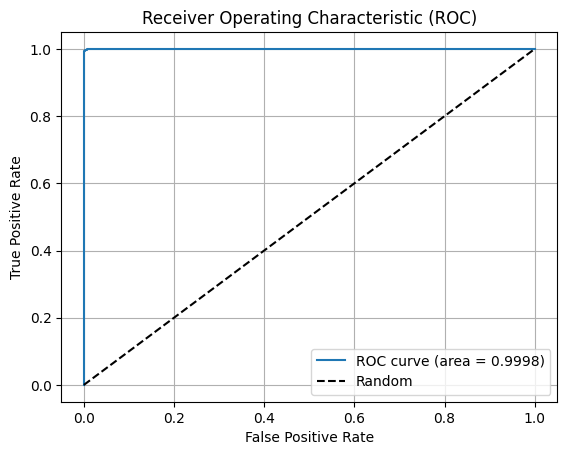

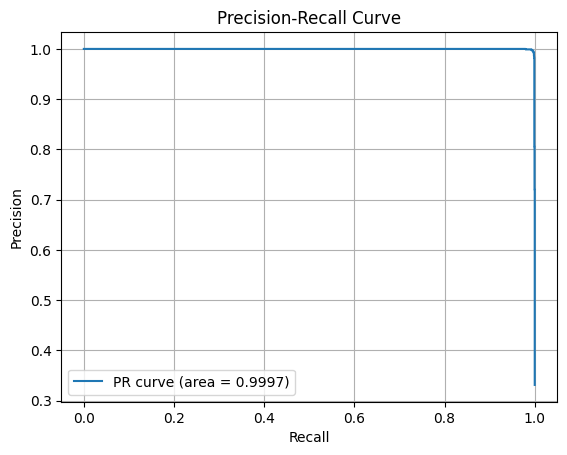

In [8]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt

# --- ROC Curve ---
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# --- Precision-Recall Curve ---
precision, recall, _ = precision_recall_curve(y_true, y_scores)
pr_auc = auc(recall, precision)

plt.figure()
plt.plot(recall, precision, label=f"PR curve (area = {pr_auc:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.grid()
plt.show()


In [9]:
emb1_array = np.vstack(emb1_list)
emb2_array = np.vstack(emb2_list)
y_true = np.array(y_true)
y_scores = np.array(y_scores)
y_pred = (y_scores > 0.5).astype(int)


In [10]:
correct_mask = y_pred == y_true
incorrect_mask = y_pred != y_true


In [11]:
# Troba la primera parella ben classificada
idx_correct = np.where(correct_mask)[0][0]
print("Exemple BEN classificat:")
print("Text A:", test_examples[idx_correct].texts[0])
print("Text B:", test_examples[idx_correct].texts[1])
print("Label real:", y_true[idx_correct], "Predicció:", y_pred[idx_correct], "Similitud:", y_scores[idx_correct])
print("Embedding A:", emb1_array[idx_correct][:10], "...")  # Mostrem només els primers valors per espai
print("Embedding B:", emb2_array[idx_correct][:10], "...")

# Troba la primera parella MAL classificada
idx_incorrect = np.where(incorrect_mask)[0][0]
print("\nExemple MAL classificat:")
print("Text A:", test_examples[idx_incorrect].texts[0])
print("Text B:", test_examples[idx_incorrect].texts[1])
print("Label real:", y_true[idx_incorrect], "Predicció:", y_pred[idx_incorrect], "Similitud:", y_scores[idx_incorrect])
print("Embedding A:", emb1_array[idx_incorrect][:10], "...")
print("Embedding B:", emb2_array[idx_incorrect][:10], "...")


Exemple BEN classificat:
Text A: The ratio $R_\mathrm{c}$ of the cluster interaction SCS to the overall SCS and the minimum single-scatterer SCS, $\mathrm{R}_{\mathrm{min}}$, satisfy %              R_\mathrm{c}\leq\min\left\{\frac{N-1}{N},1-N\mathrm{R}_{\mathrm{min}}\right\}.      %
Text B: It holds that                   \mathrm{R}_{\mathrm{max}}=\frac{1}{N^2}         if and only if                      \mathrm{R}_{n}=\frac{1}{N^2},\quad \mbox{\rm{for all}} \quad n=1,\ldots,N.      %
Label real: 1.0 Predicció: 1 Similitud: 0.9469985365867615
Embedding A: [-0.00158262 -0.00074888  0.05212693  0.00855924 -0.00110467  0.01792208
 -0.00742544  0.05383715 -0.00140612  0.04987342] ...
Embedding B: [-0.00363411  0.00471011  0.05795415  0.00241218 -0.00272299  0.02327619
 -0.01937209  0.06054309 -0.00754078  0.04019536] ...

Exemple MAL classificat:
Text A: [Approximation bound for  CNN] 		With the same settings as in Theorem \ref{Th:my_bound_extend_new} 		and for a purely convolutional netwo

In [12]:
print(idx_incorrect)

204


In [13]:
import pandas as pd

# Extraiem els índexs de les prediccions incorrectes
incorrect_indices = np.where(incorrect_mask)[0]

# Preparem les dades per guardar
rows = []
for idx in incorrect_indices:
    rows.append({
        "text_a": test_examples[idx].texts[0],
        "text_b": test_examples[idx].texts[1],
        "label_real": y_true[idx],
        "prediccio": y_pred[idx],
        "similitud": y_scores[idx]
    })

# Creem el DataFrame i el guardem
df_errors = pd.DataFrame(rows)
df_errors.to_csv("parelles_mal_classificades.csv", index=False)


In [14]:
import umap

# Ex: UMAP de la suma dels embeddings
emb_sum = emb1_array + emb2_array
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine', random_state=42)
proj = umap_model.fit_transform(emb_sum)


c:\Users\MGestioTI\Desktop\tfg\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\MGestioTI\Desktop\tfg\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [15]:
model.eval()

y_true_train = []
y_scores_train = []

with torch.no_grad():
    for example in tqdm(train_examples, desc="Evaluando en TRAIN"):
        emb1 = model.encode(example.texts[0], convert_to_tensor=True, device=device)
        emb2 = model.encode(example.texts[1], convert_to_tensor=True, device=device)
        sim = cosine_similarity(emb1.unsqueeze(0), emb2.unsqueeze(0)).item()
        y_true_train.append(example.label)
        y_scores_train.append(sim)

# Métricas en TRAIN
auc_train = roc_auc_score(y_true_train, y_scores_train)
acc_train = accuracy_score(y_true_train, [1 if s > 0.5 else 0 for s in y_scores_train])

print(f"TRAIN AUC: {auc_train:.4f}")
print(f"TRAIN Accuracy (umbral 0.5): {acc_train:.4f}")


Evaluando en TRAIN: 100%|██████████| 26618/26618 [37:38<00:00, 11.78it/s] 

TRAIN AUC: 1.0000
TRAIN Accuracy (umbral 0.5): 0.9943


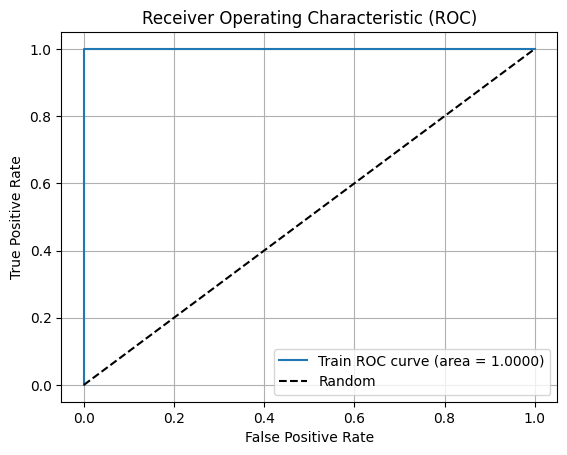

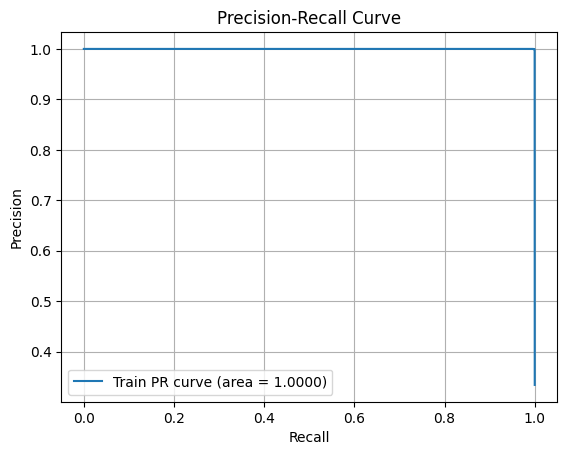

In [16]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt

# --- ROC Curve ---
fpr, tpr, _ = roc_curve(y_true_train, y_scores_train)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"Train ROC curve (area = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# --- Precision-Recall Curve ---
precision, recall, _ = precision_recall_curve(y_true_train, y_scores_train)
pr_auc = auc(recall, precision)

plt.figure()
plt.plot(recall, precision, label=f"Train PR curve (area = {pr_auc:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.grid()
plt.show()


In [17]:
# Carrega chunks
chunks = pd.concat([df['text_a'], df['text_b']]).drop_duplicates().reset_index(drop=True)
df_chunks = pd.DataFrame({'chunk_text': chunks})


In [18]:
from sentence_transformers import SentenceTransformer

# Carrega model preentrenat i fine-tuned
model_pre = SentenceTransformer("nomic-ai/modernbert-embed-base")
model_ft = SentenceTransformer("output/modernbert-contrastive-manual")

# Agafa tots els texts a visualitzar
texts = df_chunks['chunk_text'].tolist()

model_pre.max_seq_length = 512
emb_pre = model_pre.encode(
    texts, 
    convert_to_numpy=True, 
    show_progress_bar=True, 
    device="cuda",
)

model_ft.max_seq_length = 512
emb_ft = model_ft.encode(
    texts, 
    convert_to_numpy=True, 
    show_progress_bar=True, 
    device="cuda"
)


Batches: 100%|██████████| 55/55 [00:36<00:00,  1.51it/s]


In [19]:
import umap.umap_ as umap

umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine', random_state=42)
proj_pre = umap_model.fit_transform(emb_pre)
proj_ft = umap_model.fit_transform(emb_ft)



c:\Users\MGestioTI\Desktop\tfg\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\MGestioTI\Desktop\tfg\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\MGestioTI\Desktop\tfg\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [20]:
df_chunks.head()

,chunk_text
0,We define approximate peak time $t^{p}_0$ by t...
1,Let $\ell=100 \; {\rm ps}$. Supposing that $x...
2,"Let $x_d, \; x_s\in\partial\Omega$, and assume..."
3,We first study the asymptotic behavior of the ...
4,The approximate peak time for a small fluoresc...


In [21]:
df_blocks = pd.read_csv("df_blocks.csv")


In [22]:
df_chunks = df_chunks.merge(
    df_blocks,
    left_on="chunk_text",
    right_on="content",   # on el text és idèntic
    how="left"
)
# Pots quedar-te amb les columnes que vulguis:
df_chunks = df_chunks[["chunk_text", "type", "article_id"]]


In [23]:
df_chunks.head()

,chunk_text,type,article_id
0,We define approximate peak time $t^{p}_0$ by t...,definition,2502.01037
1,Let $\ell=100 \; {\rm ps}$. Supposing that $x...,example,2502.01037
2,"Let $x_d, \; x_s\in\partial\Omega$, and assume...",lemma,2502.01037
3,We first study the asymptotic behavior of the ...,proof,2502.01037
4,The approximate peak time for a small fluoresc...,theorem,2502.01037


In [24]:
print(len(labels), proj_pre.shape, proj_ft.shape)


2 (1757, 2) (1757, 2)


In [25]:
# Només els que tenen article_id vàlid i que existeixen als embeddings
mask_valid = df_chunks['article_id'].notna().values[:proj_pre.shape[0]]

labels = df_chunks.loc[:proj_pre.shape[0]-1, 'article_id'][mask_valid].astype(str).reset_index(drop=True)
proj_pre_valid = proj_pre[mask_valid]
proj_ft_valid = proj_ft[mask_valid]


In [26]:
print(len(labels), proj_pre.shape, proj_ft.shape)


1757 (1757, 2) (1757, 2)


In [27]:
import numpy as np
import pandas as pd

# Suposem que tens:
# - df_chunks: DataFrame amb tants files com embeddings (ex: 1757 files, amb chunk_text, article_id, etc)
# - proj_pre, proj_ft: arrays (N, 2) d'embeddings UMAP

# Primer, només selecciona els primers N files de df_chunks (on N = proj_pre.shape[0])
N = proj_pre.shape[0]
df_plot = df_chunks.iloc[:N].copy()

# Si vols garantir que no hi ha NaN a article_id:
mask_valid = df_plot['article_id'].notna()
df_plot = df_plot.loc[mask_valid].reset_index(drop=True)
proj_pre_valid = proj_pre[mask_valid.values]
proj_ft_valid = proj_ft[mask_valid.values]

C:\Users\MGestioTI\AppData\Local\Temp\ipykernel_14376\2893868661.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels))  # O 'tab20' si tens molts tipus


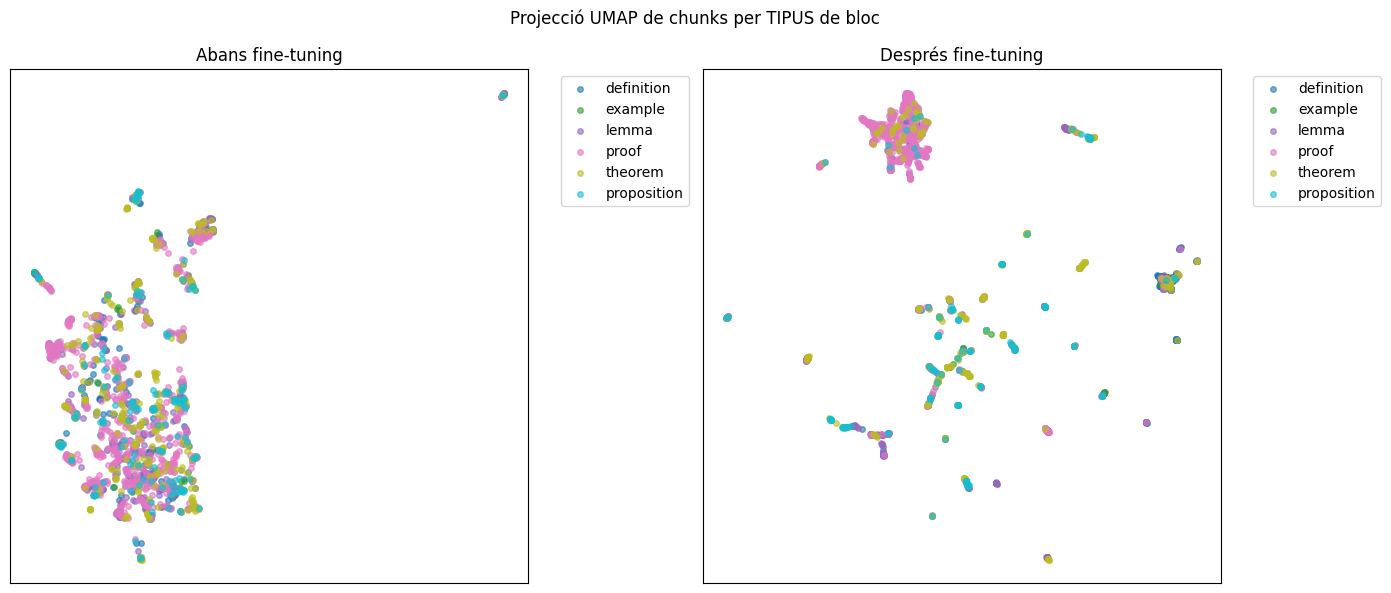

In [28]:
labels = df_plot['type'].astype(str)
unique_labels = labels.unique()
colors = plt.cm.get_cmap('tab10', len(unique_labels))  # O 'tab20' si tens molts tipus

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
for i, (proj, title) in enumerate(zip([proj_pre_valid, proj_ft_valid], ['Abans fine-tuning', 'Després fine-tuning'])):
    for idx, label in enumerate(unique_labels):
        mask = labels == label
        axes[i].scatter(proj[mask, 0], proj[mask, 1], label=label, alpha=0.6, s=16, color=colors(idx))
    axes[i].set_title(title)
    axes[i].legend(fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[i].set_xticks([])
    axes[i].set_yticks([])

plt.suptitle('Projecció UMAP de chunks per TIPUS de bloc')
plt.tight_layout()
plt.show()


In [29]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("output/modernbert-contrastive-manual")
model.max_seq_length = 512  # Límita a 512 tokens


In [30]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

#  Fes servir la GPU (device='gpu')
emb_a = model.encode(df_test['text_a'].tolist(), convert_to_numpy=True, device='cuda', batch_size=2, show_progress_bar=True)
emb_b = model.encode(df_test['text_b'].tolist(), convert_to_numpy=True, device='cuda', batch_size=2, show_progress_bar=True)


Batches: 100%|██████████| 3328/3328 [02:53<00:00, 19.15it/s]


In [31]:
import umap.umap_ as umap

# Ex: sumar els embeddings de cada parella (hi ha moltes opcions: resta, concat, etc)
emb_parelles = emb_a + emb_b

umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine', random_state=42)
proj = umap_model.fit_transform(emb_parelles)


c:\Users\MGestioTI\Desktop\tfg\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\MGestioTI\Desktop\tfg\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [32]:
import numpy as np

def cosine_sim(a, b):
    # a, b = arrays (n, d)
    return np.sum(a * b, axis=1) / (np.linalg.norm(a, axis=1) * np.linalg.norm(b, axis=1))

sims = cosine_sim(emb_a, emb_b)
df_test['prediccio'] = (sims > 0.5).astype(int)  # Umbral de 0.5, igual que l'avaluació


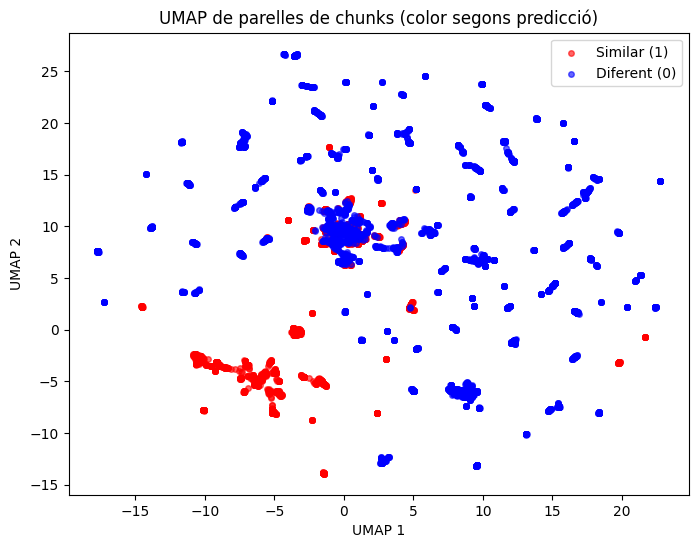

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(proj[df_test['prediccio'] == 1, 0], proj[df_test['prediccio'] == 1, 1], 
            c='red', label='Similar (1)', alpha=0.6, s=16)
plt.scatter(proj[df_test['prediccio'] == 0, 0], proj[df_test['prediccio'] == 0, 1], 
            c='blue', label='Diferent (0)', alpha=0.6, s=16)
plt.legend()
plt.title('UMAP de parelles de chunks (color segons predicció)')
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()


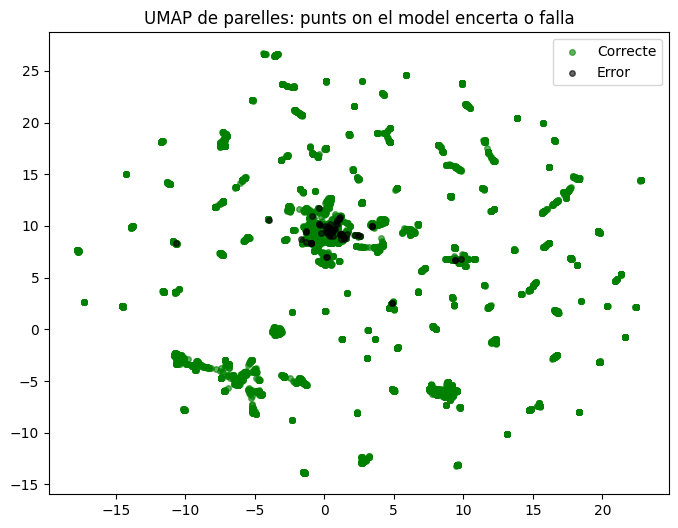

In [34]:
# Ex: df_parelles['label_real'] = la columna amb el label real

plt.figure(figsize=(8, 6))
mask_ok = df_test['prediccio'] == df_test['label']
plt.scatter(proj[mask_ok, 0], proj[mask_ok, 1], c='green', label='Correcte', alpha=0.6, s=16)
plt.scatter(proj[~mask_ok, 0], proj[~mask_ok, 1], c='black', label='Error', alpha=0.6, s=16)
plt.legend()
plt.title('UMAP de parelles: punts on el model encerta o falla')
plt.show()


In [35]:
df_test

,Unnamed: 0,text_a,text_b,label,len_a,len_b,max_len,prediccio
8880,8880,The ratio $R_\mathrm{c}$ of the cluster intera...,It holds that \mathrm{R}_{\m...,1,80,63,80,1
12976,12976,}{\hfill \interlinepenalty500 $\Box$,"From Lemma \ref{lemqfu}, it follows that: \t ...",0,12,537,537,0
1243,1243,[Sobolev lemma] \tFor any $f(x)\in H^2(\Omega_...,For any $\alpha_h\in(\mathbb{Z}_{\geqslant 0})...,1,80,244,244,1
1255,1255,[Properties of weights] For any $\sigma\in ...,For any $\alpha_h\in(\mathbb{Z}_{\geqslant 0})...,1,563,142,563,1
23578,23578,"Along with hypotheses \ref{a6}, suppose the fo...","By Lemma~\ref{lem:coloring K5}, for every $1 ...",0,199,227,227,0
...,...,...,...,...,...,...,...,...
15756,15756,"Fix $\ell_1,\ell_2 \in \mathbb N$. For $n\geq ...",Let $G$ be a $k$-planar graph with $n$ vertice...,0,177,252,252,0
22806,22806,"Let $X\in \Sm/k$ be a cellular scheme, let $V\...",[Berry’s random wave property] Let $\Omega...,0,112,179,179,0
31829,31829,"Let $(\ell_1,\ldots,\ell_m)\in \mathbb N^m$, w...",As summarized in Proposition \ref{prop:Avantag...,0,194,438,438,0
30249,30249,[Proof of Theorem D] Choose a precompact and c...,\cite[Theorems 1-2-4]{li15} Let us suppose tha...,0,1815,85,1815,0


In [36]:
# A df tens: text_a, text_b, label, prediccio, (altres...)
errors = df_test[df_test['prediccio'] != df_test['label']]

# Veure les primeres files d'errors
print(errors[['text_a', 'text_b', 'label', 'prediccio']].head(10))


                                                  text_a  \
32025  [Approximation bound for  CNN] \t\tWith the sa...   
14533  [Sequential composition of maps] Let $\Phi:Q_1...   
10128  For any set $\Delta\subseteq\Omega$, we can fi...   
30265  For the distribution given in (1.8) and under ...   
22303  When $p_0, p_1 \geq \frac{1}{2}$, the optimal ...   
13099  Let $2\leq k\leq 3$ and $1\leq a_1\leq \ldots ...   
18650  Let $L \# R$ denote $S^1 \times B^3 \# S^1 \ti...   
28437  Every connected graph \(G = (V,E)\) with at le...   
29186  The approximate peak time for a large fluoresc...   
28773  [Properties of $\HCT$ basis] \t \t% \tWe have ...   

                                                  text_b  label  prediccio  
32025  The second moment of this activation is:   \ma...      0          1  
14533  Consider a sequence $\{T_i\}_{i > 0}$ of opera...      0          1  
10128  [\cite{BabaiSzemeredi1984}]   For $j>1$,   the...      1          0  
30265  %Let $n\in\NN$. We have 

In [37]:
print(len(errors))

66


In [38]:
errors.head()

,Unnamed: 0,text_a,text_b,label,len_a,len_b,max_len,prediccio
32025,32025,[Approximation bound for CNN] \t\tWith the sa...,The second moment of this activation is: \ma...,0,272,94,272,1
14533,14533,[Sequential composition of maps] Let $\Phi:Q_1...,Consider a sequence $\{T_i\}_{i > 0}$ of opera...,0,183,148,183,1
10128,10128,"For any set $\Delta\subseteq\Omega$, we can fi...","[\cite{BabaiSzemeredi1984}] For $j>1$, the...",1,83,123,123,0
30265,30265,For the distribution given in (1.8) and under ...,"%Let $n\in\NN$. We have $H_1^{(n,0)}=(U^{(n,0)...",0,283,227,283,1
22303,22303,"When $p_0, p_1 \geq \frac{1}{2}$, the optimal ...",[Generalized variational expressions] Let $\ma...,0,375,275,375,1


In [46]:
parelles_malcalssificades = pd.read_csv("parelles_mal_classificades.csv")
parelles_malcalssificades.head()

,text_a,text_b,label_real,prediccio,similitud
0,"[Approximation bound for CNN] \t\tWith the same settings as in Theorem \ref{Th:my_bound_extend_new} \t\tand for a purely convolutional network without biases, where each layer applies \( c_l \) filters of size \( p_l \times p_l \), we have: \t\t \t\t \t\t\t \t\t\t\t&\sup_{x \in \Omega}\| R_{\theta}(x) - R_{\theta'}(x) \|_{\infty} \\ \t\t\t\t&\leq D \times \sum_{l=1}^{L} p_{l}^2 c_{l-1} \times r_{conv}^{L-1} \|\theta - \theta'\|_\infty \t\t\t \t\t \t\twhere we define \t\t \t\t\tr_{conv} := \sqrt[L-1]{\max_{l=1, \dots, L}\prod\limits_{\substack{k=1 \\ k \neq l}}^{L} r^{\text{conv}}_k} \t\t \t\t \t\twith $r^{conv}_k$ a bound on the norm of the convolutional matrix of layer $k$ without bias (i.e. $r^{conv}_k \geq \|\mathcal{H}_k\|_{op,\infty}$).",The second moment of this activation is: \mathbb{E}[F(x)^2] = a_0^2 + \frac{1}{2}\sum_{k=1}^{n} \left( a_k^2 + b_k^2 \right) The proof relies on the orthonormality property \ref{property:fourier_ortho} and is detailed in Appendix \ref{appendix:fourier}.,0.0,1,0.636988
1,"[Sequential composition of maps] Let $\Phi:Q_1\to R_1Q_2S_1, \Psi:Q_2\to R_2S_2$ be two CP maps and write $R^2:=R_1R_2$, $S^2:=S_1S_2$, then for any $1\leq q,r,s\leq\infty$ \|\Psi\circ\Phi\|_{cb,(Q_1:q)\to(R^2:r,S^2:s)} &\leq \|\Psi\|^{+}_{cb,(Q_2:q)\to(R_2:r,S_2:s)} \cdot \|\Phi\|^{+}_{cb,(Q_1:q)\to(R_1:r,Q_2:q,S_1:s)}.","Consider a sequence $\{T_i\}_{i > 0}$ of operators of the form $T_i(\theta) = \theta + h V_i(\theta)$, where $V_i(\theta)$ is a vector field on the parameter space. Then for any choice of indices $i_1, \dots, i_k$ we have that T_{i_1} \cdots T_{i_k}= 1 + h \sum_{l=1}^k V_{i_l} + h^2 \sum_{1\leq u < v \leq k} V_{i_u}' V_{i_v} + \mathcal O(h^3)",0.0,1,0.703327
2,"For any set $\Delta\subseteq\Omega$, we can find the set $\Delta^{C(X)}$ in time $n|X|$. If desired, for all $\gamma\in \Delta^{C(X)}$, we can in that same time find an $\beta\in \Delta$ and a word representing an element $g$ of $C(X)$ with $\beta^g=\gamma$.","[\cite{BabaiSzemeredi1984}] For $j>1$, the cube $C(x_1,\ldots,x_j)$ is non-degenerate iff both of the following hold: \item The cube $C(x_1,\ldots,x_{j-1})$ is non-degenerate. \item The element $x_j$ satisfies $x_j\not\in C(x_1,\ldots,x_{j-1})^{-1}C(x_1,\ldots,x_{j-1})$.",1.0,0,0.254620
3,"For the distribution given in (1.8) and under the assumptions of Theorem \ref{mgf.theo}, the following recurrence relation is satisfied \t\t \t\t\tM_{r,s,n,m,k}^{p,q}(t_{1},t_{2})=\dfrac{\gamma_{s}}{(q+1)}\left[M_{r,s,n,m,k}^{p,q+1}(t_{1},t_{2})-M_{r,s-1,n,m,k}^{p,q+1}(t_{1},t_{2})\right]-\left(\dfrac{2-\theta}{2}\right)\dfrac{\gamma_{s}^{k-m,n+1}C^{*}}{(q+1)}\nonumber \\ \,\,\,\,\,\, \t\t\t\times\left[M_{r,s,n+1,m,k-m}^{p,q+1}(t_{1},t_{2})-M_{r,s-1,n+1,m,k-m}^{p,q+1}(t_{1},t_{2})\right]- \dfrac{t_{2}}{(q+1)}M_{r,n,m,k}^{p,q+1}(t_{1},t_{2}),\,\, m\ne-1\,\,\","%Let $n\in\NN$. We have $H_1^{(n,0)}=(U^{(n,0)})^TD^{(n,0)}U^{(n,0)}$ where $D=\diag(((-1)^k)_{k\geq 0})$ and $U=(u_{i,j})_{i,j\geq 0}$ with %$$u_{i,j}=1_{2\NN_0(j-i)}(-1)^{(j-i)/2} \frac{(i+1)^{(j-i)}}{({i+2})^{(\frac{j-i}{2})}(\frac{j-i}{2})!}=1_{2\NN_0(j-i)}(-1)^{(j-i)/2} \frac{i+1}{j+1}\binom{j+1}{(j-i)/2}$$ %where $l^{(k)}$ with $l,k\in\NN$ denotes the rising factorial $l(l+1)\cdots(l+k-1)$. %",0.0,1,0.788734
4,"When $p_0, p_1 \geq \frac{1}{2}$, the optimal policy choices at the two states are: \item $b \in [0, b_l) $ a_0 = p_0, ~ a_1 = \eta_1^{-}(b), &\mbox{if}~ |\frac{1}{2} - p_1 | \geq |\frac{1}{2} - p_0 |\\ a_0 = \eta_0^{-}(b), ~ a_1 = p_1, &\mbox{if} ~ |\frac{1}{2} - p_1 | < |\frac{1}{2} - p_0 | \item $b \in [b_l, b_h)$ & a_0 = a_1 = -M(\frac{b}{2} - \mathbf{d}_{0}^\gamma p_0 - \mathbf{d}_{1}^\gamma p_1 ) \item $b \in [b_h, \infty)$ & a_0 = a_1 = \frac{1}{2} where we defined b_l & = 2\max\{(1 -\gamma p_0 - \mathbf{d}^{\gamma}_0 )(p_1 - p_0), \notag\\ &\qquad\qquad\qquad (\mathbf{d}^{\gamma}_0 +\gamma p_1)(p_0 - p_1)\}\\ \t\tb_h & = (2\mathbf{d}^{\gamma}_0 +\gamma)(p_0 - p_1)+2p_1-1\\ M & = \f

In [56]:
import pandas as pd

# Carrega el CSV
df = pd.read_csv("parelles_mal_classificades.csv")

# Classificació d'errors
falsos_positius = df[(df["label_real"] == 0) & (df["prediccio"] == 1)]
falsos_negatius = df[(df["label_real"] == 1) & (df["prediccio"] == 0)]

print(f"Falsos positius: {len(falsos_positius)}")
print(f"Falsos negatius: {len(falsos_negatius)}")

# Estadístiques de similitud
print("\n--- Estadístiques de similitud ---")
print(f"Mitjana FP: {falsos_positius['similitud'].mean():.4f}")
print(f"Mitjana FN: {falsos_negatius['similitud'].mean():.4f}")

# Mostra exemples amb similitud més alta i més baixa
def mostra_extrems(df, tipus, n=2):
    print(f"\n {tipus.upper()} - similitud més alta:")
    print(df.sort_values(by="similitud", ascending=False)[["text_a", "text_b", "similitud"]].head(n))
    print(f"\n {tipus.upper()} - similitud més baixa:")
    print(df.sort_values(by="similitud", ascending=True)[["text_a", "text_b", "similitud"]].head(n))




Falsos positius: 64
Falsos negatius: 2

--- Estadístiques de similitud ---
Mitjana FP: 0.6398
Mitjana FN: 0.2707


In [57]:
mostra_extrems(falsos_positius, "Falsos positius")


 FALSOS POSITIUS - similitud més alta:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    text_a  \
49                                                                                                                                                                                         Given a tensor $\cX\in\RR^{n_1\times \dots\times n_d}$, the Tucker decomposition of $\cX$ is defined as \[ \cX\approx \cc{C}\times_1 A^{(1)}\times_2 A^{(2)}\dots \times_N A^{(d)}, \] where $\cc{C}\in\RR^{m_1\times \dots\times m_d}$ is the core tensor and $A^{(j)}\in\RR^{n_j\times m_j}$.   
33  

In [ ]:
text_a_net = "Given a tensor , the Tucker decomposition of  is defined as"
text_b_net = "For, the cube  is non-degenerate iff both of the following hold: \item The cube  is non-degenerate. \item The element  satisfies."

<>:2: SyntaxWarning: invalid escape sequence '\i'
<>:2: SyntaxWarning: invalid escape sequence '\i'
C:\Users\MGestioTI\AppData\Local\Temp\ipykernel_14376\1196289757.py:2: SyntaxWarning: invalid escape sequence '\i'
  text_b_net = "For ,   the cube  is non-degenerate iff both of the following hold: \item The cube  is non-degenerate. \item The element  satisfies."


In [83]:
texta = "Given a tensor $\cX\in\RR^{n_1\times \dots\times n_d}$, the Tucker decomposition of $\cX$ is defined as \[ \cX\approx \cc{C}\times_1 A^{(1)}\times_2 A^{(2)}\dots \times_N A^{(d)}, \] where $\cc{C}\in\RR^{m_1\times \dots\times m_d}$ is the core tensor and $A^{(j)}\in\RR^{n_j\times m_j}$."
textb = "[\cite{BabaiSzemeredi1984}]   For $j>1$,   the cube $C(x_1,\ldots,x_j)$ is non-degenerate iff both   of the following hold:        \item The       cube $C(x_1,\ldots,x_{j-1})$ is non-degenerate.     \item The element $x_j$ satisfies       $x_j\not\in C(x_1,\ldots,x_{j-1})^{-1}C(x_1,\ldots,x_{j-1})$.   "

<>:1: SyntaxWarning: invalid escape sequence '\c'
<>:2: SyntaxWarning: invalid escape sequence '\c'
<>:1: SyntaxWarning: invalid escape sequence '\c'
<>:2: SyntaxWarning: invalid escape sequence '\c'
C:\Users\MGestioTI\AppData\Local\Temp\ipykernel_14376\2354256161.py:1: SyntaxWarning: invalid escape sequence '\c'
  texta = "Given a tensor $\cX\in\RR^{n_1\times \dots\times n_d}$, the Tucker decomposition of $\cX$ is defined as \[ \cX\approx \cc{C}\times_1 A^{(1)}\times_2 A^{(2)}\dots \times_N A^{(d)}, \] where $\cc{C}\in\RR^{m_1\times \dots\times m_d}$ is the core tensor and $A^{(j)}\in\RR^{n_j\times m_j}$."
C:\Users\MGestioTI\AppData\Local\Temp\ipykernel_14376\2354256161.py:2: SyntaxWarning: invalid escape sequence '\c'
  textb = "[\cite{BabaiSzemeredi1984}]   For $j>1$,   the cube $C(x_1,\ldots,x_j)$ is non-degenerate iff both   of the following hold:        \item The       cube $C(x_1,\ldots,x_{j-1})$ is non-degenerate.     \item The element $x_j$ satisfies       $x_j\not\in C(x_1,\l

In [ ]:
from sentence_transformers import SentenceTransformer

# Carrega el model fine-tuned
model = SentenceTransformer("output/modernbert-contrastive-manual")

# Funció per obtenir l'embedding
def get_embedding(text):
    return model.encode(text, convert_to_numpy=True)

embedding_a = get_embedding(text_a_net)
embedding_b = get_embedding(text_b_net)

from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

similaritat = cosine_similarity(
    np.expand_dims(embedding_a, axis=0),
    np.expand_dims(embedding_b, axis=0)
)[0][0]

print(f"Similitud netejada: {similaritat:.4f}")



Similitud netejada: 0.9132


In [80]:
from itertools import product

def get_sim_matrix(text_a, text_b):
    frags_a = text_a.split('. ')
    frags_b = text_b.split('. ')
    emb_a = [get_embedding(frag) for frag in frags_a]
    emb_b = [get_embedding(frag) for frag in frags_b]
    sims = np.zeros((len(emb_a), len(emb_b)))
    for i, ea in enumerate(emb_a):
        for j, eb in enumerate(emb_b):
            sims[i, j] = cosine_similarity(
                np.expand_dims(ea, 0), np.expand_dims(eb, 0)
            )[0][0]
    return frags_a, frags_b, sims


In [81]:
similitud = get_sim_matrix(text_a_net,text_b_net)
print("Fragment a: ",similitud[0])
print("Fragments b: ",similitud[1])
print("Similitud", similitud[2])

Fragment a:  ['Given a tensor , the Tucker decomposition of  is defined as']
Fragments b:  ['For ,   the cube  is non-degenerate iff both of the following hold: \\item The cube  is non-degenerate', '\\item The element  satisfies.']
Similitud [[0.9032802  0.27882308]]


In [123]:
mal_class_a = test_examples[idx_incorrect].texts[0]
mal_class_b = test_examples[idx_incorrect].texts[1]

In [ ]:
text_benclassificat_a = test_examples[idx_correct].texts[0]
text_benclassificat_b = test_examples[idx_correct].texts[1]


Label real: 1.0 Predicció: 1 Similitud: 0.9469985365867615


In [122]:
print(text_benclassificat_a)
print(text_benclassificat_b)
print("Label real:", y_true[idx_correct], "Predicció:", y_pred[idx_correct], "Similitud:", y_scores[idx_correct])


The ratio $R_\mathrm{c}$ of the cluster interaction SCS to the overall SCS and the minimum single-scatterer SCS, $\mathrm{R}_{\mathrm{min}}$, satisfy %              R_\mathrm{c}\leq\min\left\{\frac{N-1}{N},1-N\mathrm{R}_{\mathrm{min}}\right\}.      %
It holds that                   \mathrm{R}_{\mathrm{max}}=\frac{1}{N^2}         if and only if                      \mathrm{R}_{n}=\frac{1}{N^2},\quad \mbox{\rm{for all}} \quad n=1,\ldots,N.      %
Label real: 1.0 Predicció: 1 Similitud: 0.9469985365867615


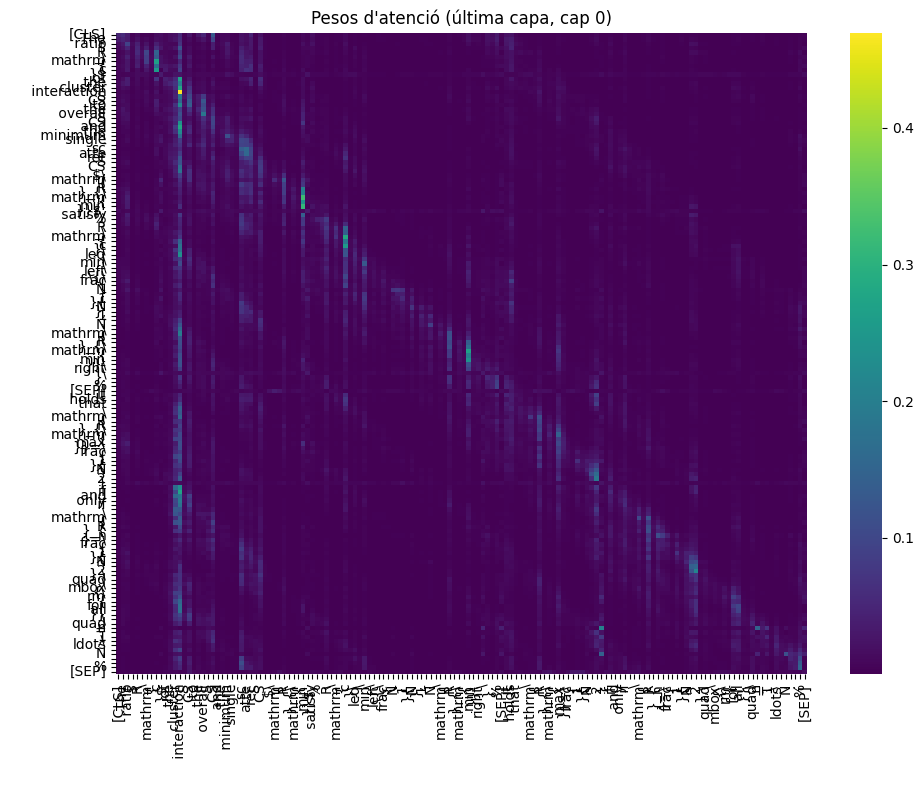

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
import matplotlib.pyplot as plt
import seaborn as sns

model_path = "output/modernbert-contrastive-manual"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModel.from_pretrained(model_path, output_attentions=True)
model.eval()



inputs = tokenizer(text_benclassificat_a, text_benclassificat_b, return_tensors="pt", padding=True, truncation=True)
with torch.no_grad():
    outputs = model(**inputs)

# Atenció de l'última capa, cap 0
att = outputs.attentions[-1][0, 0].numpy()
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
tokens = [t.replace("Ġ", " ") for t in tokens]  # reemplaça pel veritable espai

plt.figure(figsize=(10, 8))
sns.heatmap(att, xticklabels=tokens, yticklabels=tokens, cmap="viridis")
plt.title("Pesos d'atenció (última capa, cap 0)")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [115]:
# Llindar màxim de longitud per considerar un text "curt"
max_len = 19

# Funció auxiliar per comptar paraules
def is_short(example, max_len=max_len):
    return all(len(text.split()) <= max_len for text in example.texts)

# Inicialitza els índexs
idx_correct_short = None
idx_incorrect_short = None

# Busca la primera parella ben classificada (positiva) amb textos curts
for i in np.where(correct_mask)[0]:
    if y_true[i] == 1 and is_short(test_examples[i]):
        idx_correct_short = i
        break

# Busca la primera parella mal classificada (negativa) amb textos curts
for i in np.where(incorrect_mask)[0]:
    if y_true[i] == 0 and is_short(test_examples[i]):
        idx_incorrect_short = i
        break

# Mostra els resultats trobats
if idx_correct_short is not None:
    print("✅ Exemple BEN classificat (positiu i curt):")
    print("Text A:", test_examples[idx_correct_short].texts[0])
    print("Text B:", test_examples[idx_correct_short].texts[1])
    print("Label real:", y_true[idx_correct_short], "Predicció:", y_pred[idx_correct_short], "Similitud:", y_scores[idx_correct_short])
    print()

if idx_incorrect_short is not None:
    print("❌ Exemple MAL classificat (negatiu i curt):")
    print("Text A:", test_examples[idx_incorrect_short].texts[0])
    print("Text B:", test_examples[idx_incorrect_short].texts[1])
    print("Label real:", y_true[idx_incorrect_short], "Predicció:", y_pred[idx_incorrect_short], "Similitud:", y_scores[idx_incorrect_short])
    print()


✅ Exemple BEN classificat (positiu i curt):
Text A: [Sobolev lemma] 	For any $f(x)\in H^2(\Omega_{\delta})$, we have  	\[\|f\|_{L^\infty_x}\leqslant C\sum_{k+l\leqslant 2}\delta^{l-\frac{1}{2}}\|\nabla^k_h\partial_3^lf\|_{L^2_x}.\]
Text B: For any $\alpha_h\in(\mathbb{Z}_{\geqslant 0})^2$  with  	$0\leqslant|\alpha_h|\leqslant N+2$, there hold 	 		\delta^{-\frac{3}{2}}\partial_h^{\alpha_h}z^3_{\pm}(\infty;u_\mp,x_2,x_3)\in L^2(\mathcal{C}_\pm,\langle u_\mp\rangle^{2(1+\sigma)}du_\mp dx_2dx_3), 	 	and  	  		\lim_{T\to\infty}\Big\|\delta^{-\frac{3}{2}}\partial_h^{\alpha_h}z^3_{\pm}(\infty;u_\mp,x_2,x_3)-\delta^{-\frac{3}{2}}\partial_h^{\alpha_h}z^3_{\pm}(T,u_\mp\mp T,x_2,x_3)\Big\|_{L^2(\mathcal{C}_\pm,\langle u_\mp\rangle^{2(1+\sigma)}du_\mp dx_2dx_3)}=0.
Label real: 1.0 Predicció: 1 Similitud: 0.9761090278625488

❌ Exemple MAL classificat (negatiu i curt):
Text A: We have $\det(H_1^{(n)})=\pm 1$ as well as $\det(H_2^{(n)})=\pm 1$ for all $n\in\NN$.
Text B: Suppose we sift an element $g

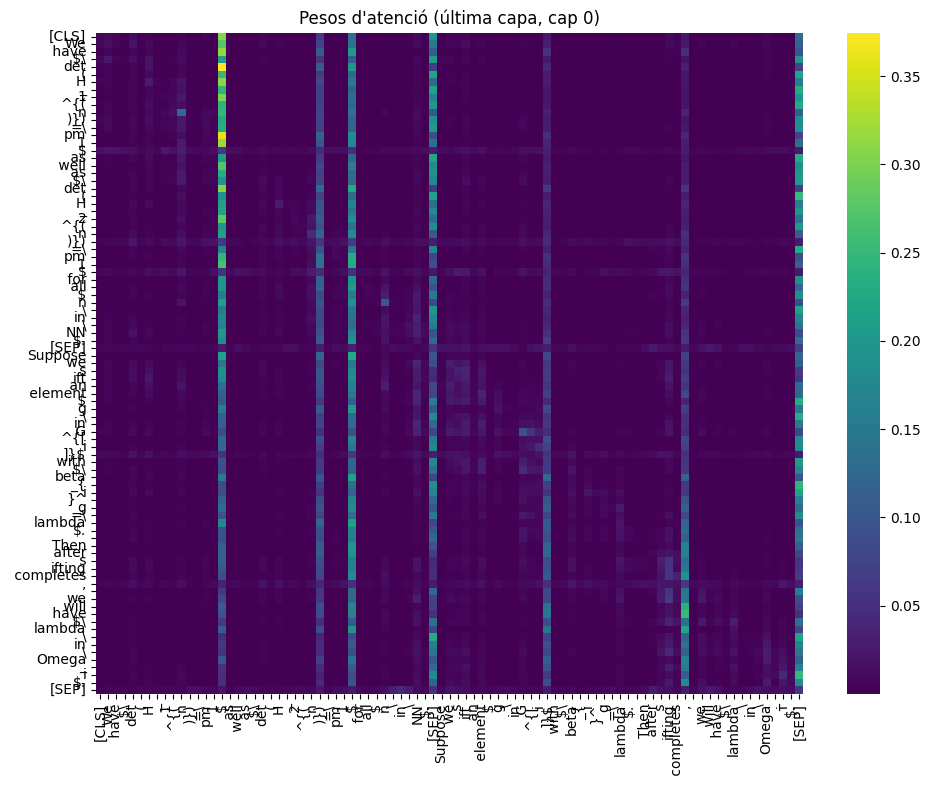

In [117]:
from transformers import AutoTokenizer, AutoModel
import torch
import matplotlib.pyplot as plt
import seaborn as sns

model_path = "output/modernbert-contrastive-manual"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModel.from_pretrained(model_path, output_attentions=True)
model.eval()



inputs = tokenizer( test_examples[idx_incorrect_short].texts[0],  test_examples[idx_incorrect_short].texts[1], return_tensors="pt", padding=True, truncation=True)
with torch.no_grad():
    outputs = model(**inputs)

# Atenció de l'última capa, cap 0
att = outputs.attentions[-1][0, 0].numpy()
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
tokens = [t.replace("Ġ", " ") for t in tokens]  # reemplaça pel veritable espai

plt.figure(figsize=(10, 8))
sns.heatmap(att, xticklabels=tokens, yticklabels=tokens, cmap="viridis")
plt.title("Pesos d'atenció (última capa, cap 0)")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [127]:
# Suposem que ja tens les següents variables definides:
# - test_examples: llista de InputExample amb .texts = [text_a, text_b]
# - y_true: etiquetes reals (0 o 1)
# - y_pred: prediccions del model
# - correct_mask: np.array booleà amb True si classificació correcta
# - emb1_array, emb2_array: embeddings de text_a i text_b (opcional)

# --- Criteri: parella ben classificada, etiqueta negativa, textos curts ---
max_len = 250  # ajusta segons el que consideris "curt"
for i in np.where(correct_mask)[0]:
    if y_true[i] == 0 and y_pred[i] == 0:
        text_a = test_examples[i].texts[0]
        text_b = test_examples[i].texts[1]
        sim = cosine_similarity([emb1_array[i]], [emb2_array[i]])[0][0]
        if len(text_a) < max_len and len(text_b) < max_len:
            print("Parella ben classificada NEGATIVA:")
            print(f"Text A: {text_a}\n")
            print(f"Text B: {text_b}\n")
            print(f"Etiqueta real: {y_true[i]}  Predicció: {y_pred[i]}")
            print(f"Similitud: {sim:.4f}")
            break


Parella ben classificada NEGATIVA:
Text A: In the limit case, by a simple injection of $a_k = \frac{1}{k^p}$ in Prop.~\ref{prop:hermite_equality} and then in Prop.~\ref{prop:hermite_backward_gain}, we obtain the result.

Text B: [Proposition 3.16 in \cite{delHoyoFernandes2018}]\th Let $\G \rightrightarrows M$ be a Lie groupoid. A $2$-metric $\eta^{(2)}$ on $\G^{(2)}$ induces a $1$-metric $\eta^{(1)}$ on $\G$.

Etiqueta real: 0.0  Predicció: 0
Similitud: 0.0863


<>:12: SyntaxWarning: invalid escape sequence '\c'
<>:12: SyntaxWarning: invalid escape sequence '\c'
C:\Users\MGestioTI\AppData\Local\Temp\ipykernel_14376\4234564604.py:12: SyntaxWarning: invalid escape sequence '\c'
  neg_correct_b = "[Proposition 3.16 in \cite{delHoyoFernandes2018}]\th Let $\G \rightrightarrows M$ be a Lie groupoid. A $2$-metric $\eta^{(2)}$ on $\G^{(2)}$ induces a $1$-metric $\eta^{(1)}$ on $\G$."


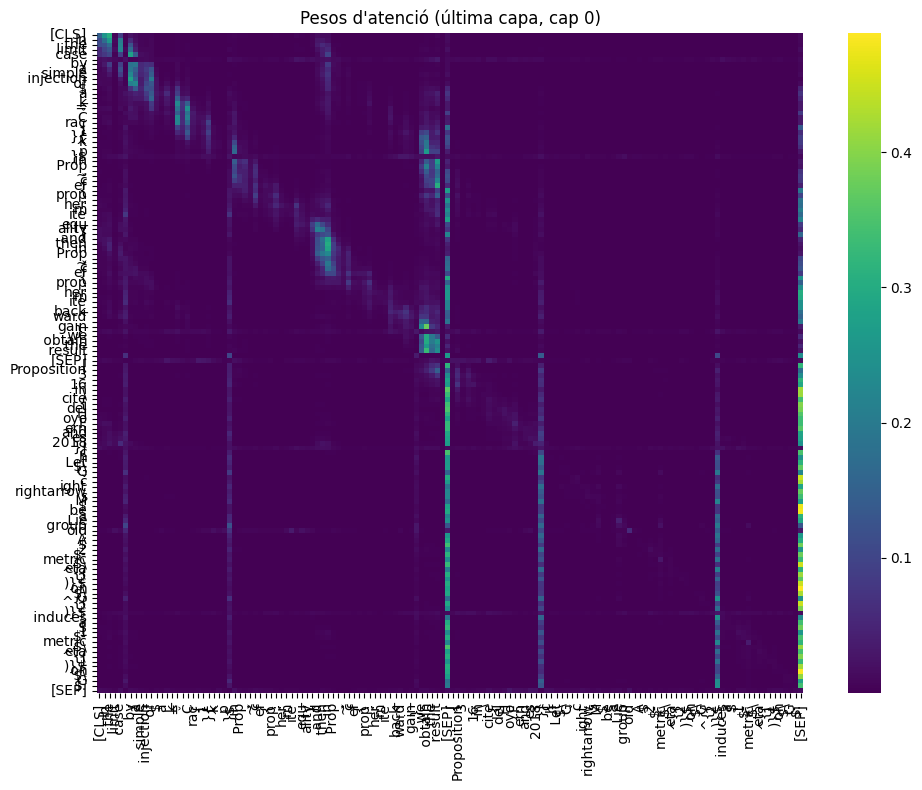

In [128]:
from transformers import AutoTokenizer, AutoModel
import torch
import matplotlib.pyplot as plt
import seaborn as sns

model_path = "output/modernbert-contrastive-manual"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModel.from_pretrained(model_path, output_attentions=True)
model.eval()

neg_correct_a= "In the limit case, by a simple injection of $a_k = \frac{1}{k^p}$ in Prop.~\ref{prop:hermite_equality} and then in Prop.~\ref{prop:hermite_backward_gain}, we obtain the result."
neg_correct_b = "[Proposition 3.16 in \cite{delHoyoFernandes2018}]\th Let $\G \rightrightarrows M$ be a Lie groupoid. A $2$-metric $\eta^{(2)}$ on $\G^{(2)}$ induces a $1$-metric $\eta^{(1)}$ on $\G$."


inputs = tokenizer( neg_correct_a,neg_correct_b, return_tensors="pt", padding=True, truncation=True)
with torch.no_grad():
    outputs = model(**inputs)

# Atenció de l'última capa, cap 0
att = outputs.attentions[-1][0, 0].numpy()
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
tokens = [t.replace("Ġ", " ") for t in tokens]  # reemplaça pel veritable espai

plt.figure(figsize=(10, 8))
sns.heatmap(att, xticklabels=tokens, yticklabels=tokens, cmap="viridis")
plt.title("Pesos d'atenció (última capa, cap 0)")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [58]:
mostra_extrems(falsos_negatius, "Falsos negatius")



 FALSOS NEGATIUS - similitud més alta:
                                                                                                                                                                                                                                                                text_a  \
34                                                                                                                                                     For any $\beta\in\Omega$ and $g\in C(X)$, we can compute $\beta^g$ in time $O(|X|)$ from the word encoding $g$.   
2   For any set $\Delta\subseteq\Omega$, we can find the set $\Delta^{C(X)}$ in time $n|X|$. If desired, for all $\gamma\in \Delta^{C(X)}$, we can in that same time find an $\beta\in \Delta$ and a word representing an element $g$ of $C(X)$ with $\beta^g=\gamma$.   

                                                                                                                                                                 

In [59]:
# Parelles amb similitud ≈ 0.5 (casos ambigus)
ambigus = df[(df["similitud"] > 0.48) & (df["similitud"] < 0.52)]
print(f"\n Casos ambigus (similitud ~0.5): {len(ambigus)}")
print(ambigus[["text_a", "text_b", "label_real", "prediccio", "similitud"]].head(3))


 Casos ambigus (similitud ~0.5): 5
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    